In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
MFCC_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/mfcc_data.json"
MEL_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/mel_data.json"

## Prepare data


In [32]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd


def load_data(data_path, feature):

    """Load dataset from json file.

        Parameters:
        data_path (str): Path to json file 
        feature (str): name of feature to load

        Returns:
        X (ndarray): Inputs
        y (ndarray): Labels
        """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # cConvert lists to numpy arrays
    X = np.array(data[feature])
    y = np.array(data["labels"])

    print("Shape of",feature,"dataset is:", X.shape)
    # print("Image values are in the range [", X.min(),",",X.max(),"]\n")
    
    return  X, y


def split_data(data_path, feature, test_size, val_size):

  """ Split data into train, test and validation datasets and prepare them
      before feeding to CNN.

      Parameters:
      data_path (str): path to dataset
      test_size (int): prefered size of test set
      val_size (int): prefered size of validation set


      Returns:
      X_train (ndarray): train set
      y_train (ndarray): train labels
      X_test (ndarray): test set
      y_test (ndarray): test labels
      X_val (ndarray): val set
      y_val (ndarray): val labels


      """

  # Load data
  X, y = load_data(data_path, feature)

  # Create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  # Create train/val split
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)


  # Add axis to create 4D inputs for the CNN
  X_train = X_train[..., np.newaxis] # 4D arrays --> (num of samples, time bins, coeffs, 1)
  X_test = X_test[..., np.newaxis]
  X_val = X_val[..., np.newaxis]

  print("\nDataset is split into train, test and validation datasets...")
  print("Train data shape is:", X_train.shape)
  print("Test data shape is:", X_test.shape)
  print("Validation data shape is:", X_val.shape)


  return X_train, X_val, X_test, y_train, y_val, y_test



## CNN architecture

In [33]:
def create_model(input_shape):

    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) 
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax')) # 10 outputs for 10 different genres

    return model

def plot_history(history):
    
    # Accuracy plot
    plt.plot(history.history["accuracy"], label="train accuracy")
    plt.plot(history.history["val_accuracy"], label="test accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc="lower right")
    plt.title("Accuracy")
    plt.show()

    # Loss plot
    plt.plot(history.history["loss"], label="train error")
    plt.plot(history.history["val_loss"], label="test error")
    plt.ylabel("Error")
    plt.xlabel("Epochs")
    plt.legend(loc="upper right")
    plt.title("Error")
    plt.show()


def predict(model, X, y):
    
    # Add dimension - model.predict() expects 4d array
    X = X[np.newaxis, ...] # array shape (1, time bins, mfcc coeffs, 1)

    # Predict
    prediction = model.predict(X)

    # Transform predicted label from probability to int
    predicted_index = np.argmax(prediction, axis=1)

    print("Ground truth:", y,"\nPredicted label:", predicted_index)


## Train on MFCC data

Shape of mfcc dataset is: (999, 130, 13)

Dataset is split into train, test and validation datasets...
Train data shape is: (599, 130, 13, 1)
Test data shape is: (250, 130, 13, 1)
Validation data shape is: (150, 130, 13, 1)

Start training...

Epoch 1/250
19/19 [==============================] - 2s 79ms/step - loss: 2.7631 - accuracy: 0.1102 - val_loss: 2.7700 - val_accuracy: 0.0800
Epoch 2/250
19/19 [==============================] - 1s 67ms/step - loss: 2.3822 - accuracy: 0.2421 - val_loss: 2.3964 - val_accuracy: 0.1067
Epoch 3/250
19/19 [==============================] - 1s 67ms/step - loss: 2.1399 - accuracy: 0.2554 - val_loss: 2.1829 - val_accuracy: 0.1333
Epoch 4/250
19/19 [==============================] - 1s 67ms/step - loss: 1.9131 - accuracy: 0.3105 - val_loss: 2.0335 - val_accuracy: 0.2267
Epoch 5/250
19/19 [==============================] - 1s 68ms/step - loss: 1.7274 - accuracy: 0.3623 - val_loss: 1.9003 - val_accuracy: 0.2933
Epoch 6/250
19/19 [===========================

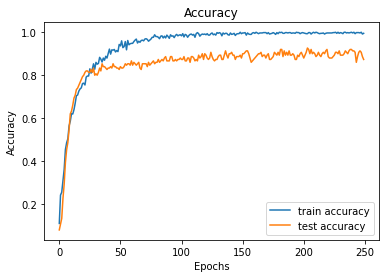

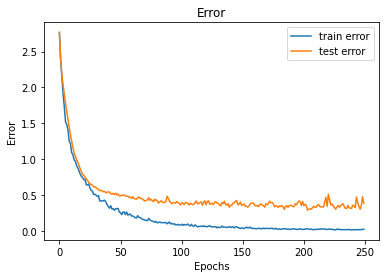


Test accuracy: 0.8479999899864197 

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.93      0.72      0.81        18
           2       0.90      0.67      0.77        27
           3       0.57      0.89      0.70        27
           4       1.00      0.83      0.91        29
           5       0.96      0.93      0.94        27
           6       1.00      1.00      1.00        21
           7       0.68      0.62      0.65        21
           8       0.93      0.93      0.93        27
           9       0.88      0.92      0.90        25

    accuracy                           0.85       250
   macro avg       0.87      0.84      0.85       250
weighted avg       0.87      0.85      0.85       250



Distribution of test data per genre:

Label ( 0 ) pop --> 28 examples
Label ( 1 ) hiphop --> 18 examples
Label ( 2 ) jazz --> 27 examples
Label ( 3 ) blues --> 27 examples
Label 

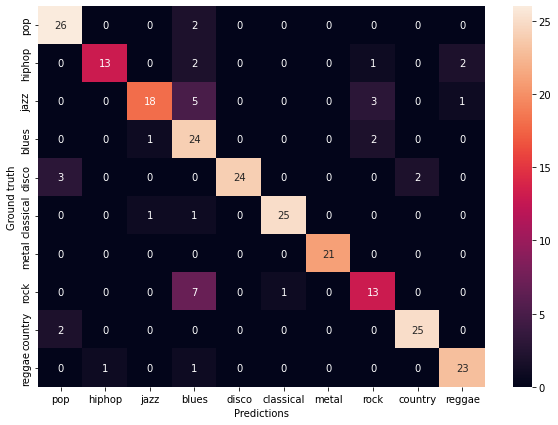

In [34]:
# Prepare data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(MFCC_DATA_PATH, "mfcc", 0.25, 0.2)

# Get model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # -->  (130, 13, 1)
model = create_model(input_shape)

# Compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()


 # Train model
print("\nStart training...\n")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=250, verbose=1)
print("Training results:")

# Plot history
plot_history(history)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', test_acc,"\n")

# Predict
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # cast probability to int
print("Classification report:\n",classification_report(y_test, y_pred))
print("\n")

labels =  ['pop', 'hiphop', 'jazz', 'blues', 'disco', 'classical', 'metal', 'rock', 'country', 'reggae']

# Check the number of test data per class
print("Distribution of test data per genre:\n")
for i in range(len(labels)): 
  print("Label (", i, ")", labels[i], "-->", np.count_nonzero(y_test == i), "examples" )

# Check the number of predicted values in each genre
print("\nDistribution of predictions per genre:\n")
for i in range(len(labels)): 
  print("Label (", i, ")", labels[i], "-->", np.count_nonzero(y_pred == i), "examples" )

print("\n")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(conf_mat, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.show()



### K-fold cross validation

In [38]:
from sklearn.model_selection import StratifiedKFold

# Join train+val sets into single training set
X_train_cv = np.concatenate((X_train, X_val), axis=0)
y_train_cv = np.concatenate((y_train, y_val), axis=0)

# print(X_train_cv.shape, y_train_cv.shape)

# Define 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []

# Train
for train, test in kfold.split(X_train_cv, y_train_cv):
  
  print("\nTraining model...")
  input_shape = (X_train_cv.shape[1], X_train_cv.shape[2], X_train_cv.shape[3]) # -->  (130, 13, 1)
  model = create_model(input_shape)

  # Compile model
  optimiser = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Fit the model
  model.fit(X_train_cv[train], y_train_cv[train], epochs=250, batch_size=32, verbose=0)

  # Evaluate the model
  scores = model.evaluate(X_train_cv[test], y_train_cv[test], verbose=0)
  print("Results:")
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

print("\n")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Training model...
Results:
accuracy: 84.67%

Training model...
Results:
accuracy: 92.00%

Training model...
Results:
accuracy: 90.00%

Training model...
Results:
accuracy: 88.67%

Training model...
Results:
accuracy: 89.93%


89.05% (+/- 2.44%)
